### Global variables

To get the list of model checkpoints available: https://huggingface.co/models?sort=downloads

[Recommended values](https://github.com/google-research/bert#bert):

* epochs: 5
* batch-sizes: 8, 16, 32, 64, 128
* learning-rates: 3e-4, 1e-4, 5e-5, 3e-5

In [1]:
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
EPOCHS = 5
BINARY_CLASS = False
CHECKPOINT = 'xlm-roberta-base'

### Set Main Paths

In [2]:
import os

try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

if os.path.isdir('/content/drive'): # Google Drive
    save_dir = '/content/drive/MyDrive/models'
    platform = 'colab'
elif os.path.isdir('kaggle/working'): # Kaggle
    save_dir = 'kaggle/working'
    platform = 'kaggle'
else: # Others
    save_dir = './'
    platform = 'other'

corpus_folder = '../input/riposte/cpca/sampled/'

### Libraries

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam, AdamW

from transformers import AutoTokenizer, AutoModel, get_scheduler, AutoModelForSequenceClassification

import pandas as pd

from collections import defaultdict

from tqdm import tqdm

import matplotlib.pyplot as plt

import numpy as np

import os

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Check if GPU available

In [4]:
torch.cuda.is_available()

True

In [5]:
if torch.cuda.is_available():
    !nvidia-smi

Mon May 23 16:39:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Check dataset

In [6]:
df = pd.read_csv(corpus_folder + "dev_multi.csv", sep="\t")
df.head()

,topic,claim,premise,<begging>,<hasty>,<none>,<questionable_cause>,<red_herring>,types
0,Are Family Vacations Worth It?,Parents should make vacation with kids,Family vacations create lifelong memories.,1,1,0,0,0,"<begging>,<hasty>"
1,Will Electric Cars Finally Succeed?,Electric cars will succeed,The cost efficiency of electric cars will make...,1,1,0,0,0,"<begging>,<hasty>"
2,Are Court Stenographers Necessary?,Court stenographers are necessary,Somebody still needs to transcribe audio recor...,1,1,0,0,0,"<begging>,<hasty>"
3,Are Casinos Too Much of a Gamble?,Casinos are too much of a gamble,If casinos are not a destination resort then t...,1,1,0,1,0,"<begging>,<hasty>,<questionable_cause>"
4,Has Support for Israel Hurt U.S. Credibility?,Supporting Israel hurts,The US sides blindly with Isreal despite what ...,0,1,0,0,0,<hasty>


### Dataset

In [7]:
class Riposte(Dataset):
    def __init__(self, dataset_path, name="", label2idx=None, idx2label=None):
        
        # Give a name to the dataset
        if name:
            print("Creating", name, "dataset")
        self.name = name
        
        # Create the BERT tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)
        
        # Read the dataset
        self.dataset_path = dataset_path
        df = pd.read_csv(self.dataset_path, sep="\t")
        
        # Variables to store the information
        self.argument_ids, self.information = [], defaultdict(lambda: defaultdict(str))
        
        # If we want binary types: Fallacy true/false
        if BINARY_CLASS:
            df.loc[df['types'] != '<none>', ['types']] = '<fallacy>' 
        
        # Create a new label2idx and idx2label or use some predifined ones.
        if label2idx is not None and idx2label is not None:
            print("Using predifined label2idx and idx2label")
            self.label2idx, self.idx2label = label2idx, idx2label
        else:
            self.label2idx, self.idx2label = defaultdict(int), defaultdict(str)
            self.label2idx['<unk>'], self.idx2label[0] = 0, '<unk>'
            
            for label_type in df['types'].unique():
                self.label2idx[label_type.lower()] = len(self.label2idx)
                self.idx2label[self.label2idx[label_type.lower()]] = label_type
        
        # Read the dataset and store the information in dictionaries for fast access
        for row_id, row_info in df.iterrows():
            self.argument_ids.append(row_id)
            if 'topic' in row_info:
                self.information[row_id]['topic'] = str(row_info['topic']).lower()
            self.information[row_id]['claim'] = str(row_info['claim']).lower()
            self.information[row_id]['premise'] = str(row_info['premise']).lower()
            type_info = str(row_info['types']).lower()
            self.information[row_id]['type'] = self.label2idx[type_info] if type_info in self.label2idx else self.label2idx['<unk>']
            self.information[row_id]['labels'] = [int(row_info['<begging>']), int(row_info['<hasty>']), int(row_info['<questionable_cause>']), int(row_info['<red_herring>'])]
            self.information[row_id]['<begging>'] = int(row_info['<begging>'])
            self.information[row_id]['<hasty>'] = int(row_info['<hasty>'])
            self.information[row_id]['<questionable_cause>'] = int(row_info['<questionable_cause>'])
            self.information[row_id]['<red_herring> 	'] = int(row_info['<red_herring>'])
            
    
    def __len__(self):
        return len(self.argument_ids)
    
    def __getitem__(self, idx):
        # Create one example for training
        
        # Obtain the argument id
        argument_id = self.argument_ids[idx]
        
        # Get the claim and the counter-argument
        claim = self.information[argument_id]['claim']
        premise = self.information[argument_id]['premise']
        
        # Use the Bert tokenizer with the claim and the carg and obtain the label type
        text = self.tokenizer(claim, premise, padding='max_length', max_length=256, truncation=True, return_tensors="pt")
        # label_type = self.information[argument_id]['type']
        labels = torch.LongTensor(self.information[argument_id]['labels'])
        
        return text, labels

In [8]:
# Create the datasets
train_ds = Riposte(corpus_folder + "train_multi.csv", name="training")
dev_ds = Riposte(corpus_folder + "dev_multi.csv", name="development", label2idx=train_ds.label2idx, idx2label=train_ds.idx2label)
test_ds = Riposte(corpus_folder + "test_multi.csv", name="testing", label2idx=train_ds.label2idx, idx2label=train_ds.idx2label)

Creating training dataset


Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Creating development dataset
Using predifined label2idx and idx2label
Creating testing dataset
Using predifined label2idx and idx2label


In [9]:
train_ds.label2idx, len(train_ds.label2idx)

(defaultdict(int,
             {'<unk>': 0,
              '<begging>': 1,
              '<red_herring>,<questionable_cause>': 2,
              '<red_herring>,<hasty>,<questionable_cause>': 3,
              '<red_herring>,<begging>,<hasty>,<questionable_cause>': 4,
              '<red_herring>,<hasty>': 5,
              '<begging>,<hasty>': 6,
              '<hasty>,<questionable_cause>': 7,
              '<red_herring>,<begging>,<hasty>': 8,
              '<begging>,<questionable_cause>': 9,
              '<hasty>': 10,
              '<begging>,<hasty>,<questionable_cause>': 11,
              '<none>': 12,
              '<red_herring>': 13,
              '<red_herring>,<begging>': 14,
              '<red_herring>,<begging>,<questionable_cause>': 15,
              '<questionable_cause>': 16}),
 17)

In [10]:
train_ds[8]

({'input_ids': tensor([[     0,   8174,      7,    621,   5792,   5045,    111,     10,    914,
           40099,      2,      2,   8174,      7,   1221,  22304,   1286, 130815,
            1295,   3395,    388,    214,   2363,   6897,  14880,   5180,   2685,
               5,      2,      1,      1,      1,      1,      1,      1,      1,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
  

In [11]:
# Create the dataloaders. These create the bathes, shuffles the data and so on for each dataset
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True)
dev_dl = DataLoader(dev_ds, BATCH_SIZE) 
test_dl = DataLoader(test_ds, BATCH_SIZE) 

### Model

In [12]:
class AutoClassifier(nn.Module):

    def __init__(self, dropout=0.2, n_classes=4):

        super(AutoClassifier, self).__init__()
        
        # Create the bert model
        self.model = AutoModel.from_pretrained(CHECKPOINT)
        self.dropout = nn.Dropout(dropout)
        
        # Create the classification layer
        self.linear = nn.Linear(768, n_classes)

    def forward(self, input_id, mask):
        input_id = input_id.squeeze(1)
        _, pooled_output = self.model(input_ids=input_id, attention_mask=mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)

        return linear_output

In [13]:
# Create the model
model = AutoClassifier()
# Create the loss
loss = nn.BCEWithLogitsLoss()

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Move to GPU

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
# Obtain the device
device = get_default_device()
print(device)

cuda


In [16]:
# Move the model to GPU (if there is one)
model = to_device(model, device)

In [17]:
# Move the loss to GPU (if there is one)
loss = to_device(loss, device)

### Train

In [18]:
def train(model, train_dl, dev_dl, loss, optimizer, epochs):
    
    # Store the accuracies, losses and the best epoch in development
    history = {"accuracy_train": [], "precision_train": [], "recall_train": [], "f1_score_train": [], "loss_train": [], 
               "accuracy_dev": [], "precision_dev": [], "recall_dev": [], "f1_score_dev": [], "loss_dev":[]}
    best_epoch, best_acc = 0, 0
    
    # Create the scheduler
    num_training_steps = epochs * len(train_dl)
    lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
    
    train_size, dev_size = len(train_dl) * BATCH_SIZE, len(dev_dl) * BATCH_SIZE

    # Training loop
    for epoch in range(epochs):
        
        print("Starting epoch", epoch+1)
        
        print("Training")
        model.train()
        
        total_acc_train, total_loss_train = 0, 0
        y_gold, y_pred = np.array([]), np.array([])
        
        # Check each batch
        for batch in tqdm(train_dl):
            text, label = batch
            
            # move the inputs and the expected label to GPU (if there is one)
            text_input_ids = text['input_ids'].to(device)
            text_attention_mask = text['attention_mask'].to(device)
            
            labels = label.to(device, dtype=torch.float)
            
            # Apply the model
            output = model(text_input_ids, text_attention_mask)
            
            # get the loss
            batch_loss = loss(output, labels)
            
            outputs = torch.sigmoid(output.detach())
            outputs = outputs >= 0.5
            
            total_loss_train += batch_loss.item()
            
            y_gold = np.concatenate((y_gold, label.numpy().flatten()))
            y_pred = np.concatenate((y_pred, outputs.cpu().int().numpy().flatten()))
            
            
            model.zero_grad()
            
            batch_loss.backward()
            
            optimizer.step()
            
            lr_scheduler.step()
            

        accuracy, precision, recall, f1 = accuracy_score(y_pred, y_gold), precision_score(y_pred, y_gold, average='weighted'), recall_score(y_pred, y_gold, average='weighted'), f1_score(y_pred, y_gold, average='weighted')

        # Print information about the training
        print(f"Accuracy (Train): {accuracy}. Precision (Train): {precision}. Recall (Train):{recall}. F1-score (Train): {f1}. Loss (Train): {total_loss_train}")
        history['accuracy_train'].append(accuracy)
        history['precision_train'].append(precision)
        history['recall_train'].append(recall)
        history['f1_score_train'].append(f1)
        history['loss_train'].append(total_loss_train)
        
        # Calculate the accuracy and loss for development
        accuracy_dev, precision_dev, recall_dev, f1_score_dev, total_loss_dev = evaluate(model, dev_dl)
        
        # If this new epoch is better store the information
        if accuracy_dev > best_acc:
            print("Best new epoch:", epoch + 1)
            best_acc = accuracy_dev
            best_epoch = epoch + 1
        
        # Print information about the training
        print(f"Accuracy (Dev): {accuracy_dev}. Precision (Dev): {precision_dev}. Recall (Dev):{recall_dev}. F1-score (Dev): {f1_score_dev}. Loss (Dev): {total_loss_dev}")
        history['accuracy_dev'].append(accuracy_dev)
        history['precision_dev'].append(precision_dev)
        history['recall_dev'].append(recall_dev)
        history['f1_score_dev'].append(f1_score_dev)
        history['loss_dev'].append(total_loss_dev)
        
        # Store the epoch
        if not os.path.exists(f"{save_dir}/checkpoints/"):
            os.mkdir(f"{save_dir}/checkpoints/")
            
        torch.save(model.state_dict(), f"{save_dir}/checkpoints/" + str(epoch+1) + ".pth")
        print("Ending epoch", epoch+1, "\n")
        
    return history, best_epoch

@torch.no_grad()
def evaluate(model, val_dl):
    # Function to evaluate the model
    
    print("Testing")
    
    model.eval()
    
    total_acc_val, total_loss_val = 0, 0
    y_gold, y_pred = np.array([]), np.array([])
    # Check each batch
    for batch in tqdm(val_dl):
        text, label = batch
        
        # move the inputs and the expected label to GPU (if there is one)
        text_input_ids = text['input_ids'].to(device)
        text_attention_mask = text['attention_mask'].to(device)
        labels = label.to(device, dtype=torch.float)
        
        # Apply the model
        output = model(text_input_ids, text_attention_mask)
        
        # get the loss
        batch_loss = loss(output, labels)
        
        outputs = torch.sigmoid(output.detach())
        outputs = outputs >= 0.5
        
        total_loss_val += batch_loss.item()
        
        y_gold = np.concatenate((y_gold, label.numpy().flatten()))
        y_pred = np.concatenate((y_pred, outputs.cpu().int().numpy().flatten()))
    
   
    accuracy, precision, recall, f1 = accuracy_score(y_pred, y_gold), precision_score(y_pred, y_gold, average='weighted'), recall_score(y_pred, y_gold, average='weighted'), f1_score(y_pred, y_gold, average='weighted')

    return accuracy, precision, recall, f1, total_loss_val

In [19]:
history, best_epoch = train(model, train_dl, dev_dl, loss, AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8), EPOCHS)

Starting epoch 1
Training


100%|██████████| 125/125 [00:32<00:00,  3.85it/s]


Accuracy (Train): 0.6188688688688688. Precision (Train): 0.6268592991768627. Recall (Train):0.6188688688688688. F1-score (Train): 0.6217493383871071. Loss (Train): 82.01876050233841
Testing


100%|██████████| 17/17 [00:01<00:00, 13.91it/s]


Best new epoch: 1
Accuracy (Dev): 0.6314814814814815. Precision (Dev): 0.7106208781917591. Recall (Dev):0.6314814814814815. F1-score (Dev): 0.6546083934673813. Loss (Dev): 10.783296644687653
Ending epoch 1 

Starting epoch 2
Training


100%|██████████| 125/125 [00:31<00:00,  3.94it/s]


Accuracy (Train): 0.6268768768768769. Precision (Train): 0.6307438193640403. Recall (Train):0.6268768768768768. F1-score (Train): 0.6283981349859546. Loss (Train): 81.40973353385925
Testing


100%|██████████| 17/17 [00:01<00:00, 14.23it/s]


Accuracy (Dev): 0.6314814814814815. Precision (Dev): 0.7106208781917591. Recall (Dev):0.6314814814814815. F1-score (Dev): 0.6546083934673813. Loss (Dev): 10.791839301586151
Ending epoch 2 

Starting epoch 3
Training


100%|██████████| 125/125 [00:31<00:00,  3.94it/s]


Accuracy (Train): 0.6238738738738738. Precision (Train): 0.6270740208146521. Recall (Train):0.6238738738738738. F1-score (Train): 0.6251674546431278. Loss (Train): 81.17745637893677
Testing


100%|██████████| 17/17 [00:01<00:00, 14.17it/s]


Best new epoch: 3
Accuracy (Dev): 0.6444444444444445. Precision (Dev): 0.6483850966687335. Recall (Dev):0.6444444444444445. F1-score (Dev): 0.6420680512593903. Loss (Dev): 10.756057858467102
Ending epoch 3 

Starting epoch 4
Training


100%|██████████| 125/125 [00:31<00:00,  3.94it/s]


Accuracy (Train): 0.6241241241241241. Precision (Train): 0.6262205328721628. Recall (Train):0.6241241241241242. F1-score (Train): 0.6250134973413289. Loss (Train): 81.19888281822205
Testing


100%|██████████| 17/17 [00:01<00:00, 14.22it/s]


Accuracy (Dev): 0.6444444444444445. Precision (Dev): 0.6483850966687335. Recall (Dev):0.6444444444444445. F1-score (Dev): 0.6420680512593903. Loss (Dev): 10.751505076885223
Ending epoch 4 

Starting epoch 5
Training


100%|██████████| 125/125 [00:31<00:00,  3.94it/s]


Accuracy (Train): 0.6256256256256256. Precision (Train): 0.62446434508748. Recall (Train):0.6256256256256256. F1-score (Train): 0.6245868747180507. Loss (Train): 81.0800347328186
Testing


100%|██████████| 17/17 [00:01<00:00, 14.21it/s]


Accuracy (Dev): 0.6444444444444445. Precision (Dev): 0.6483850966687335. Recall (Dev):0.6444444444444445. F1-score (Dev): 0.6420680512593903. Loss (Dev): 10.757009148597717
Ending epoch 5 



### Plot Losses

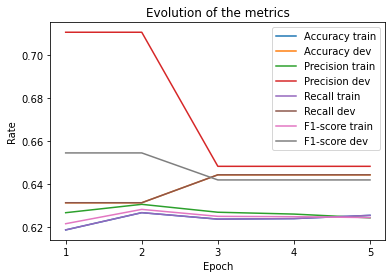

In [20]:
plt.plot(history['accuracy_train'], label="Accuracy train")
plt.plot(history['accuracy_dev'], label="Accuracy dev")
plt.plot(history['precision_train'], label="Precision train")
plt.plot(history['precision_dev'], label="Precision dev")
plt.plot(history['recall_train'], label="Recall train")
plt.plot(history['recall_dev'], label="Recall dev")
plt.plot(history['f1_score_train'], label="F1-score train")
plt.plot(history['f1_score_dev'], label="F1-score dev")
plt.title("Evolution of the metrics")
plt.xticks(np.arange(EPOCHS), np.arange(1, EPOCHS+1))
plt.xlabel("Epoch")
plt.ylabel("Rate")
plt.legend()
plt.show()

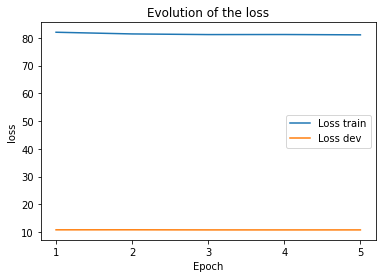

In [21]:
plt.plot(history['loss_train'], label="Loss train")
plt.plot(history['loss_dev'], label="Loss dev")
plt.title("Evolution of the loss")
plt.xticks(np.arange(EPOCHS), np.arange(1, EPOCHS+1))
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

### Check Testing Dataset

Use the epoch that gives the best results in the development dataset.

In [22]:
print("Best epoch:", best_epoch)

Best epoch: 3


In [23]:
model.load_state_dict(torch.load(f"{save_dir}/checkpoints/" + str(best_epoch) + ".pth"))               

<All keys matched successfully>

In [24]:
accuracy, precision, recall, f1, total_loss_val= evaluate(model, test_dl)

Testing


100%|██████████| 17/17 [00:01<00:00, 13.76it/s]


In [25]:
print(f"Accuracy (Test): {accuracy} Precision (Test): {precision}. Recall (Test):{recall}. F1-score (Test): {f1}")

Accuracy (Test): 0.6055555555555555 Precision (Test): 0.6066217732884399. Recall (Test):0.6055555555555555. F1-score (Test): 0.6045669729880256
